In [643]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [644]:
# Load energy data
energy_df = pd.read_csv('../data/energy_import_export.csv')

# Load solar self-consumption data
solar_df = pd.read_csv('../data/solar_self_consumption_main_building.csv')

# Load meteorological data
met_df = pd.read_csv('../data/met_data.csv')

#Load electricity pricing data
temp_spot=pd.read_csv('../data/elspot.csv', delimiter=';')
#Drop unnecessary columns
drop_columns=["HourUTC","SpotPriceDKK"]
temp_spot=temp_spot.drop(columns=drop_columns)
temp_spot=temp_spot[temp_spot["PriceArea"]=='NO2']


#load predicted data
pred_df = pd.read_csv('C:/Users/magnu/SolarEnergyImpact/data/prediciton_3features.csv')
pred_df=pred_df['value']

In [645]:
solar_df.head()
# drop columns "Unnamed: 0"
solar_df = solar_df.drop(columns=['Unnamed: 0'])

In [646]:
# Convert timestamp columns to datetime
energy_df['Tidspunkt'] = pd.to_datetime(energy_df['Tidspunkt'], format="mixed")
solar_df['starting_at'] = pd.to_datetime(solar_df['starting_at'], format='mixed')
temp_spot['HourDK']=pd.to_datetime(temp_spot['HourDK'], format='mixed')

#Remove all unneccasry values
cutoff='2023-07-01'
spot_df=temp_spot[temp_spot['HourDK']>=cutoff]


# remove utc from the time string
met_df['starting_at'] = met_df['starting_at'].str.split('+').str[0]
met_df['starting_at'] = pd.to_datetime(met_df['starting_at'], format='mixed')


In [647]:
energy_df.rename(columns={
    'Energikilde': 'energy_source',
    'Retning': 'direction',
    'Målernavn': 'meter_name',
    'Måler-Id': 'meter_id',
    'Verdi': 'value',
    'Tidspunkt': 'timestamp'
}, inplace=True)


solar_df.rename(columns={
    'starting_at': 'timestamp'
}, inplace=True)
met_df.rename(columns={
    'starting_at': 'timestamp'
}, inplace=True)

spot_df.rename(columns={
    'HourDK': 'timestamp',
    'SpotPriceEUR': 'price'
}, inplace=True)

In [648]:
meter_property_mapping = {
    '707057500042745649': 10724, #main building
    '707057500038344962': 10703, # building A
    '707057500085390523': 4462, # building B
    '707057500042201572': 4746 # building C
}
id_to_name_property_mapping= {
    10724: 'main building',
    10703: 'building A',
    4462: 'building B',
    4746: 'building C'
}
def get_name(id):
    return id_to_name_property_mapping[id]

energy_df['meter_id'] = energy_df['meter_id'].astype(str)
energy_df['meter_id'] = energy_df['meter_id'].str.strip()

energy_df['property_id'] = energy_df['meter_id'].map(meter_property_mapping)
energy_df['building'] = energy_df['property_id'].map(id_to_name_property_mapping)

energy_df.head()

,energy_source,direction,meter_name,meter_id,value,timestamp,property_id,building
0,Elektrisitet,IMPORT,Hovedmåler,707057500038344962,19.80,2023-07-01,10703,building A
1,Elektrisitet,IMPORT,Hovedmåler,707057500042201572,35.10,2023-07-01,4746,building C
2,Elektrisitet,EXPORT,Hovedmåler,707057500042745649,0.00,2023-07-01,10724,main building
3,Elektrisitet,IMPORT,Hovedmåler,707057500085390523,27.44,2023-07-01,4462,building B
4,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.50,2023-07-01,10724,main building


In [649]:
# Resample met_df to daily (mean aggregation)
# met_df_daily = met_df.set_index('timestamp').resample('D').mean().reset_index()
# met_df_daily["timestamp"] = pd.to_datetime(met_df_daily["timestamp"].dt.date)

merged_df = pd.merge(energy_df, met_df, on=['property_id', 'timestamp'], how='left')

In [650]:
merged_df.tail()

,energy_source,direction,meter_name,meter_id,value,timestamp,property_id,building,temperature,wind_speed,wind_direction,cloud_fraction,precipitation
54471,Elektrisitet,IMPORT,Hovedmåler,707057500038344962,27.40,2024-09-04 23:00:00,10703,building A,16.2,1.4,281.6,0.4,0.0
54472,Elektrisitet,IMPORT,Hovedmåler,707057500042201572,31.50,2024-09-04 23:00:00,4746,building C,18.2,4.8,14.4,0.0,0.0
54473,Elektrisitet,EXPORT,Hovedmåler,707057500042745649,0.00,2024-09-04 23:00:00,10724,main building,17.4,1.8,356.1,0.9,0.0
54474,Elektrisitet,IMPORT,Hovedmåler,707057500085390523,27.76,2024-09-04 23:00:00,4462,building B,15.6,0.9,243.3,0.9,0.0
54475,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,38.60,2024-09-04 23:00:00,10724,main building,17.4,1.8,356.1,0.9,0.0


In [651]:
met_df.tail()

,property_id,timestamp,temperature,wind_speed,wind_direction,cloud_fraction,precipitation
41179,10724,2023-07-01 01:00:00,13.2,2.0,246.5,0.4,0.0
41180,4462,2023-07-01 00:00:00,12.0,0.7,220.3,0.5,0.0
41181,4746,2023-07-01 00:00:00,15.2,3.9,247.0,0.2,0.0
41182,10703,2023-07-01 00:00:00,12.9,1.0,275.7,0.7,0.0
41183,10724,2023-07-01 00:00:00,13.6,1.6,251.5,0.5,0.0


In [652]:
# Check for missing values
print("total number of rows", merged_df.shape[0])
print("rows missing weather data \n",merged_df.isnull().sum())

# Fill or drop missing values as appropriate
# merged_df.dropna(inplace=True)
rows_with_missing_values = merged_df[merged_df.isnull().any(axis=1)]
rows_with_missing_values.head()


total number of rows 54476
rows missing weather data 
 energy_source       0
direction           0
meter_name          0
meter_id            0
value               0
timestamp           0
property_id         0
building            0
temperature       385
wind_speed        385
wind_direction    385
cloud_fraction    385
precipitation     385
dtype: int64


,energy_source,direction,meter_name,meter_id,value,timestamp,property_id,building,temperature,wind_speed,wind_direction,cloud_fraction,precipitation
29071,Elektrisitet,EXPORT,Hovedmåler,707057500042745649,0.0,2024-02-06 06:00:00,10724,main building,NaN,NaN,NaN,NaN,NaN
29072,Elektrisitet,IMPORT,Hovedmåler,707057500038344962,37.4,2024-02-06 06:00:00,10703,building A,NaN,NaN,NaN,NaN,NaN
29073,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,37.8,2024-02-06 06:00:00,10724,main building,NaN,NaN,NaN,NaN,NaN
29074,Elektrisitet,IMPORT,Hovedmåler,707057500042201572,46.4,2024-02-06 06:00:00,4746,building C,NaN,NaN,NaN,NaN,NaN
29075,Elektrisitet,IMPORT,Hovedmåler,707057500085390523,34.4,2024-02-06 06:00:00,4462,building B,NaN,NaN,NaN,NaN,NaN


In [653]:
# Separate import (consumption) and export (production)
import_df = merged_df[merged_df['direction'] == 'IMPORT']
export_df = merged_df[merged_df['direction'] == 'EXPORT']

In [654]:
# For property_id 10724 (main building)
main_building_import = import_df[import_df['property_id'] == 10724]

main_building_export = export_df[export_df['property_id'] == 10724]


# Merge with solar self-consumption data
main_building_df = pd.merge(main_building_import, solar_df, left_on='timestamp', right_on='timestamp', how='left')

# Replace NaN in solar_consumption with 0
main_building_df['solar_consumption'].fillna(0, inplace=True)

# Calculate total consumption including self-consumed solar energy
main_building_df['total_consumption'] = main_building_df['value'] + main_building_df['solar_consumption']

C:\Users\magnu\AppData\Local\Temp\ipykernel_29116\3474756120.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  main_building_df['solar_consumption'].fillna(0, inplace=True)


In [667]:
main_building_df.head()

,energy_source,direction,meter_name,meter_id,value,timestamp,property_id,building,temperature,wind_speed,wind_direction,cloud_fraction,precipitation,solar_consumption,total_consumption,netsun
0,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.5,2023-07-01 00:00:00,10724,main building,13.6,1.6,251.5,0.5,0.0,0.002687,27.502687,27.5
1,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.1,2023-07-01 01:00:00,10724,main building,13.2,2.0,246.5,0.4,0.0,0.002750,27.102750,27.1
2,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.8,2023-07-01 02:00:00,10724,main building,12.3,1.6,260.4,0.3,0.0,0.002937,26.802937,26.8
3,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,25.9,2023-07-01 03:00:00,10724,main building,11.9,0.6,285.0,0.9,0.0,0.003062,25.903062,25.9
4,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.4,2023-07-01 04:00:00,10724,main building,11.9,0.2,295.8,0.8,0.0,0.000035,26.400035,26.4


In [656]:
# Get import data for reference buildings
ref_buildings = [10703, 4462, 4746]
ref_buildings_df = import_df[import_df['property_id'].isin(ref_buildings)]

# Aggregate data to daily or monthly consumption if needed
main_daily_consumption = main_building_df.groupby(main_building_df['timestamp'].dt.date)['value'].sum()#.reset_index()

#Find the main building's consumption net of sun
main_daily_netofsun=main_daily_consumption-main_building_df.groupby(main_building_df['timestamp'].dt.date)['solar_consumption'].sum()#.reset_index()

#Get datetime on predicted so it can be aggregated
datefile=main_building_df['timestamp']
predwithdate=pd.concat([datefile,pred_df], axis=1)
predwithdate.loc[10343, 'value']=49.817900
predwithdate.loc[10344, 'value']=50.417438
predwithdate.loc[10345, 'value']=38.617267

pred_daily_consumption = predwithdate.groupby(main_building_df['timestamp'].dt.date)['value'].sum()#.reset_index()

ref_daily_consumption = ref_buildings_df.groupby(['property_id', ref_buildings_df['timestamp'].dt.date])['value'].sum().reset_index()

In [657]:
# Identify hourly peaks
main_building_peaks = main_building_df.groupby(main_building_df['timestamp'].dt.month)['total_consumption'].max()#.reset_index()
ref_buildings_peaks = ref_buildings_df.groupby(['property_id', ref_buildings_df['timestamp'].dt.month])['value'].max().reset_index()
pred_peaks=predwithdate.groupby(predwithdate['timestamp'].dt.month)['value'].max()#.reset_index()

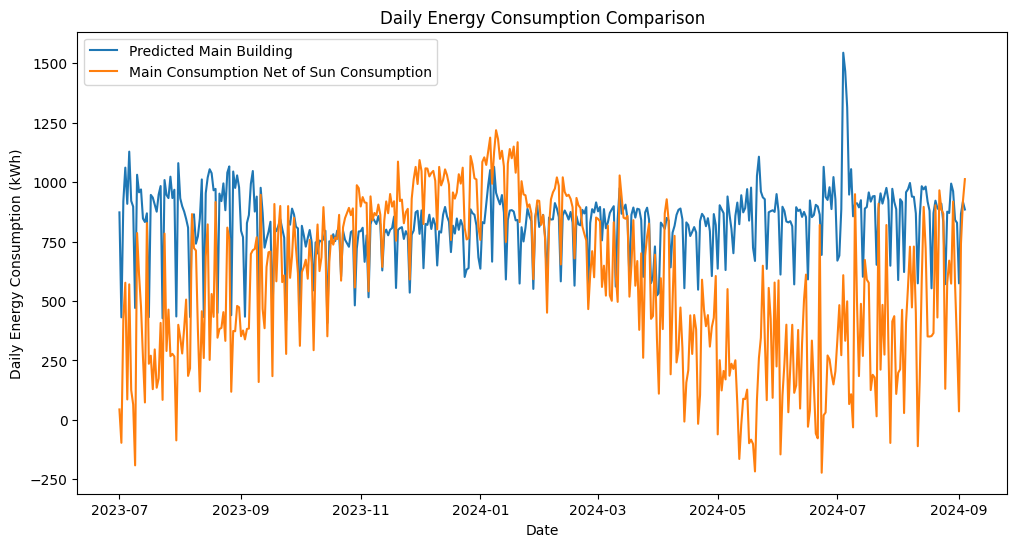

In [658]:
plt.figure(figsize=(12,6))
sns.lineplot(data=pred_daily_consumption, label='Predicted Main Building')
plt.plot(main_daily_netofsun, label='Main Consumption Net of Sun Consumption')
plt.xlabel('Date')
plt.ylabel('Daily Energy Consumption (kWh)')
plt.title('Daily Energy Consumption Comparison')
plt.legend()
plt.show()

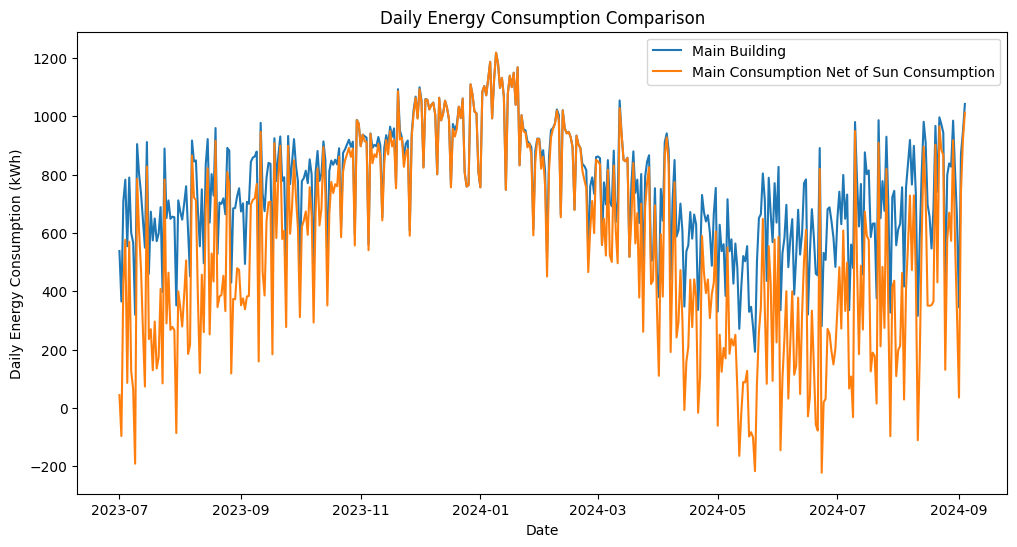

In [659]:
plt.figure(figsize=(12,6))
sns.lineplot(data=main_daily_consumption, label='Main Building')
plt.plot(main_daily_netofsun, label='Main Consumption Net of Sun Consumption')
plt.xlabel('Date')
plt.ylabel('Daily Energy Consumption (kWh)')
plt.title('Daily Energy Consumption Comparison')
plt.legend()
plt.show()

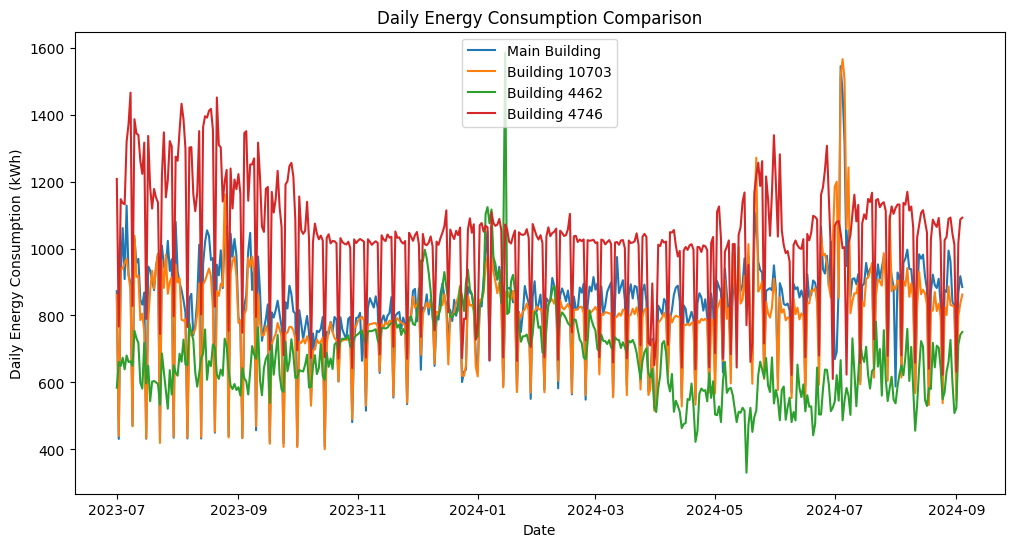

In [660]:
plt.figure(figsize=(12,6))
sns.lineplot(data=pred_daily_consumption, label='Main Building')
for pid in ref_buildings:
    data = ref_daily_consumption[ref_daily_consumption['property_id'] == pid]
    sns.lineplot(x='timestamp', y='value', data=data, label=f'Building {pid}')
plt.xlabel('Date')
plt.ylabel('Daily Energy Consumption (kWh)')
plt.title('Daily Energy Consumption Comparison')
plt.legend()
plt.show()

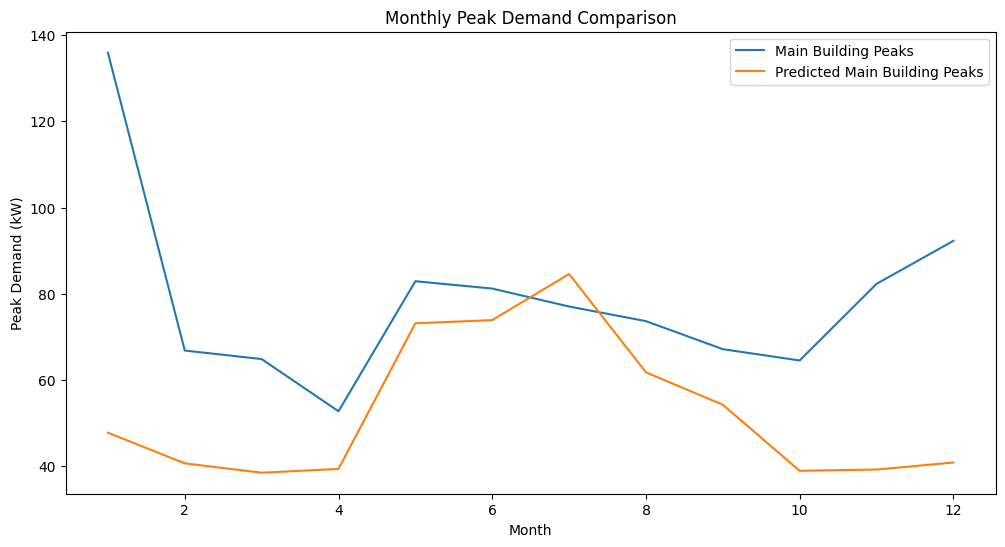

In [661]:
plt.figure(figsize=(12,6))
plt.plot(main_building_peaks.index, main_building_peaks.values, label='Main Building Peaks')
plt.plot(pred_peaks.index, pred_peaks.values, label='Predicted Main Building Peaks')
plt.xlabel('Month')
plt.ylabel('Peak Demand (kW)')
plt.title('Monthly Peak Demand Comparison')
plt.legend()
plt.show()

In [662]:
def find_peak_import(import_df: pd.DataFrame) -> pd.DataFrame:
    # Note that it is not only about having a low energy consumption but also important to reduce the monthly max kW peak as a high peak will give high tariffs.
    # TODO: skal vi finne peak per time eller forbrukt for en dag eller en uke eller en måned?
    import_df['month'] = import_df['timestamp'].dt.to_period('M')
    predwithdate['month'] = predwithdate['timestamp'].dt.to_period('M')
    pred_peak=predwithdate.groupby('month')['value'].max().reset_index()
    peak_import = import_df.groupby(['property_id', 'month'])['value'].max().reset_index()
    return peak_import,pred_peak
peak_import_df,pred_peak = find_peak_import(import_df)

C:\Users\magnu\AppData\Local\Temp\ipykernel_29116\1906259370.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import_df['month'] = import_df['timestamp'].dt.to_period('M')


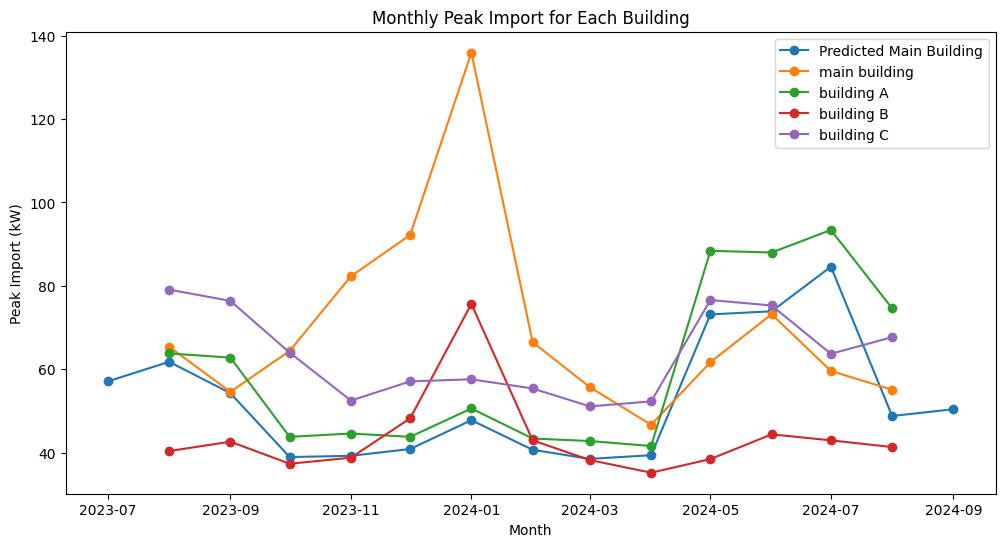

In [663]:
all_buildings = [10724, 10703, 4462, 4746]

plt.figure(figsize=(12,6))
plt.plot(pred_peak['month'].dt.to_timestamp(), pred_peak['value'], marker='o', label="Predicted Main Building")
for pid in all_buildings:
    data = peak_import_df[peak_import_df['property_id'] == pid]
    data = data[1:-1]# skip the first and last value to avoid half weeks.
    plt.plot(data['month'].dt.to_timestamp(), data['value'], marker='o', label=f'{get_name(pid)}')
plt.xlabel('Month')
plt.ylabel('Peak Import (kW)')
plt.title('Monthly Peak Import for Each Building')
plt.legend()
plt.show()

In [ ]:
#Filter so only in range we have electricity prices
main_datechange=main_building_df[main_building_df['timestamp']<='2024-02-22 23:00']
main_building_df['netsun']=main_building_df['total_consumption']-main_building_df['solar_consumption']

avgeurnok=11.69

#Fixing notation in spotprices
spot_df['price']=spot_df['price'].str.replace(',','.').astype(float)
#Change price to NOK/KWh
spot_df['price']=spot_df['price']*avgeurnok/1000

#Merging datasets
merge_main=pd.merge(main_building_df,spot_df, on='timestamp')
merge_pred=pd.merge(predwithdate,spot_df, on='timestamp')

#Finding cost for each hour
merge_main['Total']=(merge_main['price'])*merge_main['netsun']
merge_pred['Total']=(merge_pred['price']+0.05)*merge_pred['value']
merge_main['Totalfull']=(merge_main['price'])*merge_main['total_consumption']


#Making function to find the effektledd
def find_effect(df,navn_total):
    nydf=df.copy()
    nydf.set_index('timestamp', inplace=True)
    monthly_max_consumption = nydf[navn_total].resample('M').max()
    monthly_max_df = monthly_max_consumption.reset_index()
    monthly_max_df.columns = ['Month', 'Max Consumption']
    monthly_max_df['Adjusted Consumption'] = np.where(
        monthly_max_df['Month'].dt.month.isin([4, 5, 6, 7, 8, 9]),   # Summer months
        monthly_max_df['Max Consumption'] * 44,
        monthly_max_df['Max Consumption'] * 104  # Winter months (remaining)
    )
    return monthly_max_df

monthly_max_main=find_effect(main_building_df, "total_consumption")
monthly_max_pred=find_effect(predwithdate, "value")
monthly_max_net=find_effect(merge_main,'netsun')



#Finner totalt tariffforbruk
maintotalnetsun=merge_main['Total'].sum()#+monthly_max_net['Adjusted Consumption'].sum()
predtotal=merge_pred['Total'].sum()+monthly_max_pred['Adjusted Consumption'].sum()
mainbeforetotal=merge_main['Totalfull'].sum()#+monthly_max_main['Adjusted Consumption'].sum()

print(maintotalnetsun)
print(mainbeforetotal)



230594.6636019484
268669.62077810103


C:\Users\magnu\AppData\Local\Temp\ipykernel_29116\1940742184.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_max_consumption = nydf[navn_total].resample('M').max()
C:\Users\magnu\AppData\Local\Temp\ipykernel_29116\1940742184.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_max_consumption = nydf[navn_total].resample('M').max()
C:\Users\magnu\AppData\Local\Temp\ipykernel_29116\1940742184.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_max_consumption = nydf[navn_total].resample('M').max()


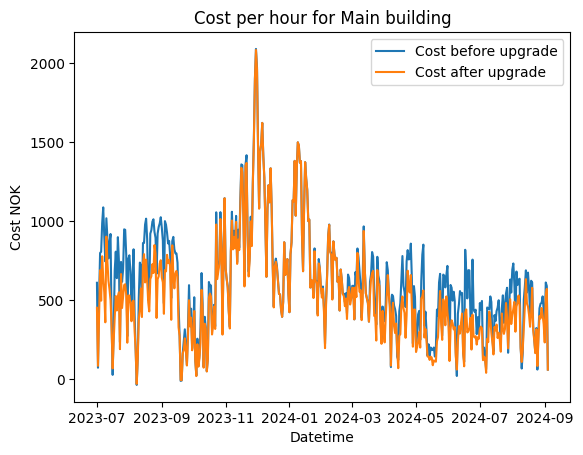

In [665]:
#Finding daily costs by aggregating
daily_main=merge_main.groupby(main_building_df['timestamp'].dt.date)['Total'].sum()#.reset_index()
daily_pred=merge_pred.groupby(main_building_df['timestamp'].dt.date)['Total'].sum()#.reset_index()
daily_mainbefore=merge_main.groupby(main_building_df['timestamp'].dt.date)['Totalfull'].sum()#.reset_index()


sns.lineplot(daily_mainbefore, label="Cost before upgrade")
sns.lineplot(daily_main, label= "Cost after upgrade")
#sns.lineplot(daily_mainbefore, label="Total consumption cost without sun panels")
plt.xlabel('Datetime')
plt.ylabel('Cost NOK')
plt.title('Cost per hour for Main building')
plt.legend()
plt.show()


Text(0, 0.5, 'Energy Consumption (kWh)')

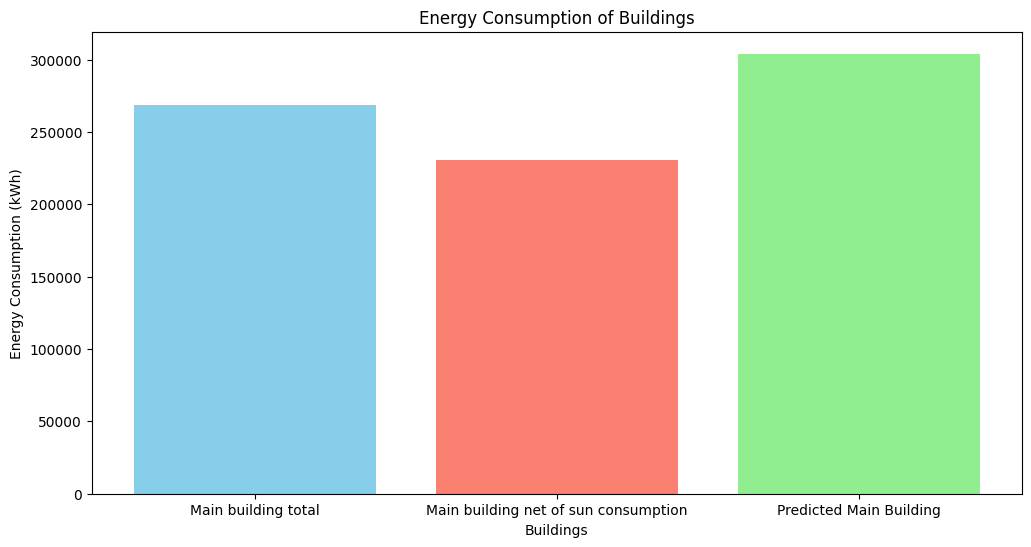

In [666]:
#Lager et plott
buildings=["Main building total",  "Main building net of sun consumption", "Predicted Main Building"]
values=[mainbeforetotal,maintotalnetsun,predtotal]

colors = ['skyblue', 'salmon', 'lightgreen']

#Create bar chart
plt.figure(figsize=(12,6))
plt.bar(buildings, values, color=colors)

# Add titles and labels
plt.title('Energy Consumption of Buildings')
plt.xlabel('Buildings')
plt.ylabel('Energy Consumption (kWh)')
